# Plotting the results -- Scenario I

In this notebook, we plot the results , i.e., the spectral efficiency obtained by using the *hybrid*, the *E2E*, and the *delay blind* approach under Scenario I. We assume that there are trained models stored in a folder to load and directly test. 

Due to storage limitations the **trained models are currently not available** in this repository. A link to an external storage will be provided soon.

Instead of running the models, the reader can directly load the spectral efficiencies obtained by the three methods over the test datasets, by setting the parameter `load_from_memory` to `True`. This can be done for two test datasets with relative speeds of 60 km/h (16.67 m/s) and 120 km/h (33.33 m/s), by setting the parameter `relative_speed` to 16.67 or 33.33, respectively.

The name of the trained neural network models (**currently not available**) are the following:

- ANN_MCS_NO_PRED_DELAY_X_DP_Y_SNR_Z for the case of the *delay-blind* appraoch
- ANN_E2E_MCS_PRED_DELAY_X_DP_Y_SNR_Z for the case of the *E2E* approach
- ANN_MCS_PRED_WIENER_DELAY_X_DP_Y_SNR_Z for the case of the *hybrid* appraoch

where X indicates the values of the delay, where Y indicates the doppler (cast to integer), and where Z indicates the SNR.

To give an example: ANN_MCS_PRED_WIENER_DELAY_1_DP_111_SNR_5

The relative velocity of 60 km/h (i.e. 16.67 m/s) corresponds to a doppler of 111.13 Hz (i.e. 111 if cast to integer) in our setup, given that the carrier frequency we work with is 2 GHz. Analogously, the relative velocity of 120 km/h (i.e. 33.33 m/s) corresponds to a doppler fo 222.22 Hz (i.e. 222 if cast to integer).

## Import libraries and utility functions

In [1]:
import numpy as np
import utilities as utils
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcdefaults()
matplotlib.rcParams.update( { 'font.size': 22,
                              'lines.linewidth': 4,
                              'lines.markersize': 15 } )

In [2]:
%run setup.ipynb

Using TensorFlow backend.


## Test the trained models

In [3]:
# Note that 'Datasets/ITU_VEHICULAR_B_5000_60kmph.npy' is currently not available
TEST_SET = 'Datasets/ITU_VEHICULAR_B_5000_60kmph.npy'
relative_speed = 16.67 # m/s It must be consistent with the doppler of the loaded dataset
DOPPLER = (2e9 / 3e8) * relative_speed
DATASET = np.load( TEST_SET, allow_pickle = True )[()]
NROF_FRAMES, NROF_SUBCARRIERS, NROF_SNRS = DATASET['channel'].shape
NROF_MCS = len( DATASET[ 'block_sizes' ] )
BLOCK_SIZES = DATASET[ 'block_sizes' ]
# Maximum feedback delat that we consider
maximum_delay = 9
# Snrs set that we consider
snrs_set = [5,15, 25]
tx_bw = 15e3 * 72 # Tranmission Bandwidth
load_from_memory = True # Flag to skip running the models and directly load the spectral efficiencies from the memory

tput_HYBRID = []
tput_DELAY_BLIND = []
tput_E2E = []
mean_squared_error_no_prediction = []
mean_squared_error_with_prediction = []

if load_from_memory == True:
    
    if relative_speed == 33.33:
        
        tput_DELAY_BLIND = np.load('Trained_models_ScenarioI/tput_DELAY-BLIND_sc_I_222.npy')
        tput_HYBRID = np.load('Trained_models_ScenarioI/tput_HYBRID_sc_I_222.npy')
        tput_E2E = np.load('Trained_models_ScenarioI/tput_E2E_sc_I_222.npy')
        mean_squared_error_with_prediction = np.load('Trained_models_ScenarioI/MSE_sc_I_222.npy')
        
    if relative_speed == 16.67:
        
        tput_DELAY_BLIND = np.load('Trained_models_ScenarioI/tput_DELAY-BLIND_sc_I_111.npy')
        tput_HYBRID = np.load('Trained_models_ScenarioI/tput_HYBRID_sc_I_111.npy')
        tput_E2E = np.load('Trained_models_ScenarioI/tput_E2E_sc_I_111.npy')
        mean_squared_error_with_prediction = np.load('Trained_models_ScenarioI/MSE_sc_I_111.npy')
    
else:
    for DELAY in range( 0, maximum_delay + 1):

        for SNR in snrs_set:

            print( 'Simulating a channel reporting delay of %d ms and SNR of %d'%( DELAY,SNR ) )   
            E2E_MODEL_FILE = 'Trained_models_ScenarioI/ANN_E2E_MCS_PRED_DELAY_%d_DP_%d_SNR_%d.h5'%(DELAY,DOPPLER,SNR )
            DELAY_BLIND_MODEL_FILE = 'Trained_models_ScenarioI/ANN_MCS_NO_PRED_DELAY_%d_DP_%d_SNR_%d.h5'%(DELAY,DOPPLER,SNR)
            HYBRID_MODEL_FILE = 'Trained_models_ScenarioI/ANN_MCS_PRED_WIENER_DELAY_%d_DP_%d_SNR_%d.h5'%( DELAY,DOPPLER,SNR ) 
           
                
            tputs, \
        error_rates, \
        mse, \
        ack_prob    = computation( TEST_SET,
                                   HYBRID_MODEL_FILE,
                                   DELAY_BLIND_MODEL_FILE,
                                   E2E_MODEL_FILE,
                                   DELAY,
                                   DOPPLER,
                                   noise = True,
                                   train_fraction = 0.2)


            tput_DELAY_BLIND.append( tputs['ann_delayed'] )
            tput_HYBRID.append( tputs['ann_ch_pr'] )
            tput_E2E.append( tputs['ann_e2e'] )

            mean_squared_error_with_prediction.append( mse['ann_ch_pr'] )



## Plotting

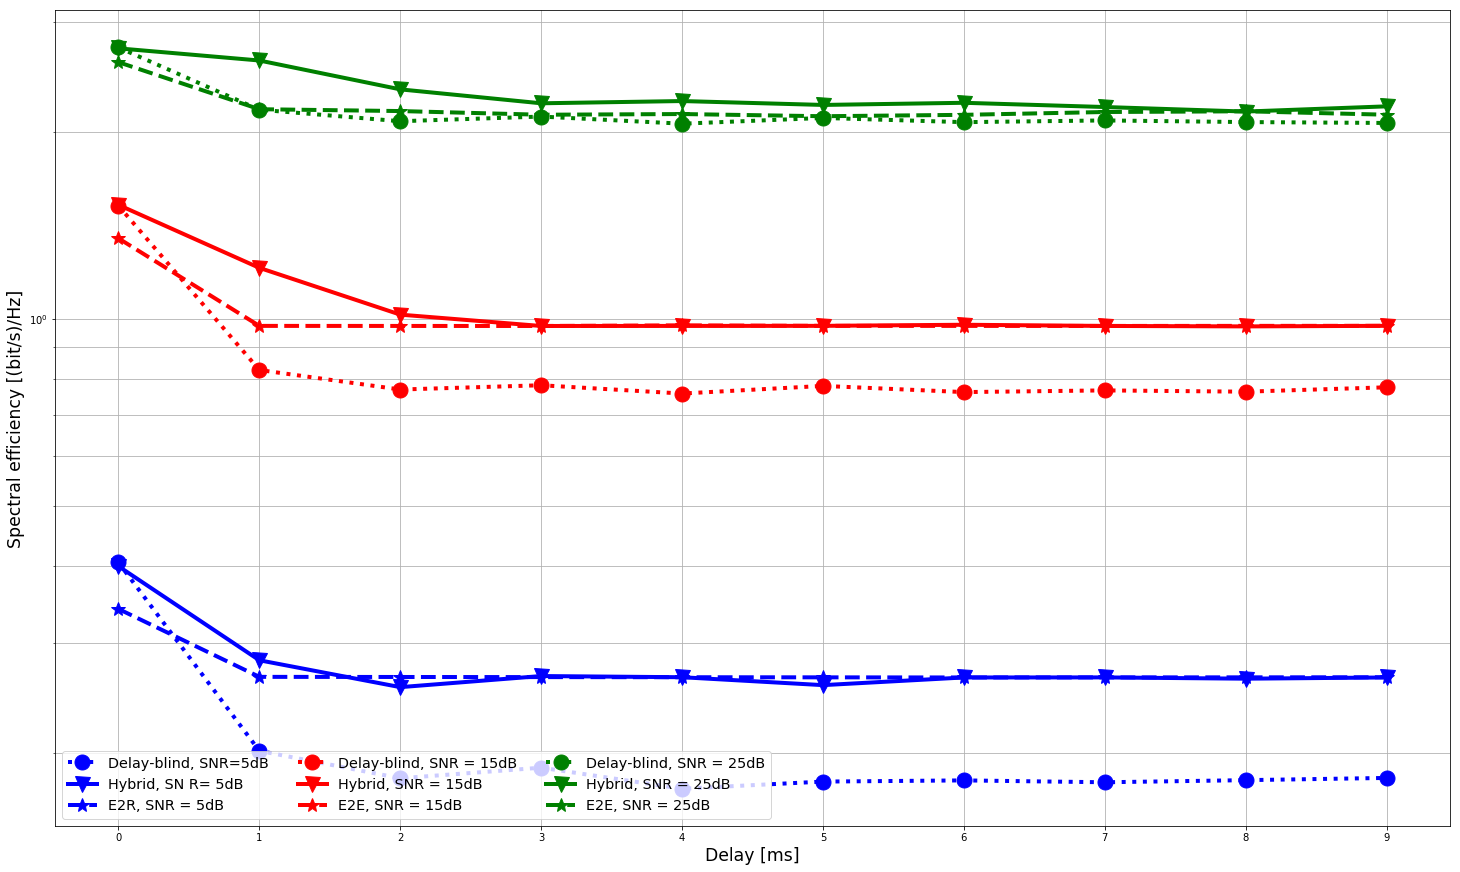

In [4]:
results_tput_delayed = np.zeros([(maximum_delay + 1), len(snrs_set)]) 
results_tput_ch_pr = np.zeros([(maximum_delay + 1), len(snrs_set)]) 
results_e2e_tput = np.zeros([(maximum_delay + 1), len(snrs_set)]) 
delays = range( 0, maximum_delay + 1)

for delay_index in range(0,maximum_delay + 1):
    
    for snr_index in [0,1,2]:
        
        results_tput_delayed[delay_index,snr_index] = (tput_DELAY_BLIND[len(snrs_set)*delay_index+snr_index][snrs_set[snr_index]-1] )/ tx_bw
        results_tput_ch_pr[delay_index,snr_index] = (tput_HYBRID[len(snrs_set)*delay_index+snr_index][snrs_set[snr_index]-1])/ tx_bw
        results_e2e_tput[delay_index,snr_index] = (tput_E2E[len(snrs_set)*delay_index+snr_index][snrs_set[snr_index]-1])/ tx_bw

plt.figure( figsize = [ 25, 15 ] )
plt.ylabel('Spectral efficiency [(bit/s)/Hz]',fontsize = 'xx-large')
plt.xlabel('Delay [ms]',fontsize = 'xx-large')

plt.semilogy( delays, results_tput_delayed[:,0], marker = 'o', color='b', linestyle = ':', label = 'Delay-blind, SNR=5dB' )
plt.semilogy( delays, results_tput_ch_pr[:,0], marker = 'v', color='b', label = 'Hybrid, SN R= 5dB' )
plt.semilogy( delays, results_e2e_tput[:,0], marker = '*', linestyle='--', color='b',label = 'E2R, SNR = 5dB' )

plt.semilogy( delays, results_tput_delayed[:,1], marker = 'o', color ='r', linestyle =':',label = 'Delay-blind, SNR = 15dB' )
plt.semilogy( delays, results_tput_ch_pr[:,1], marker = 'v', color ='r', label ='Hybrid, SNR = 15dB' )
plt.semilogy( delays, results_e2e_tput[:,1], marker = '*', linestyle ='--', color ='r',label='E2E, SNR = 15dB' )

plt.semilogy( delays, results_tput_delayed[:,2], marker = 'o', color ='g',linestyle = ':', label = 'Delay-blind, SNR = 25dB' )
plt.semilogy( delays, results_tput_ch_pr[:,2], marker = 'v', color ='g', label = 'Hybrid, SNR = 25dB' )
plt.semilogy( delays, results_e2e_tput[:,2], marker = '*', linestyle ='--',color = 'g', label = 'E2E, SNR = 25dB' )

plt.xticks(np.arange(0, 10, step = 1))

plt.grid(which = 'both')
plt.legend()
plt.legend(fontsize = 'x-large',loc = 'lower left', ncol = 3)
plt.show()

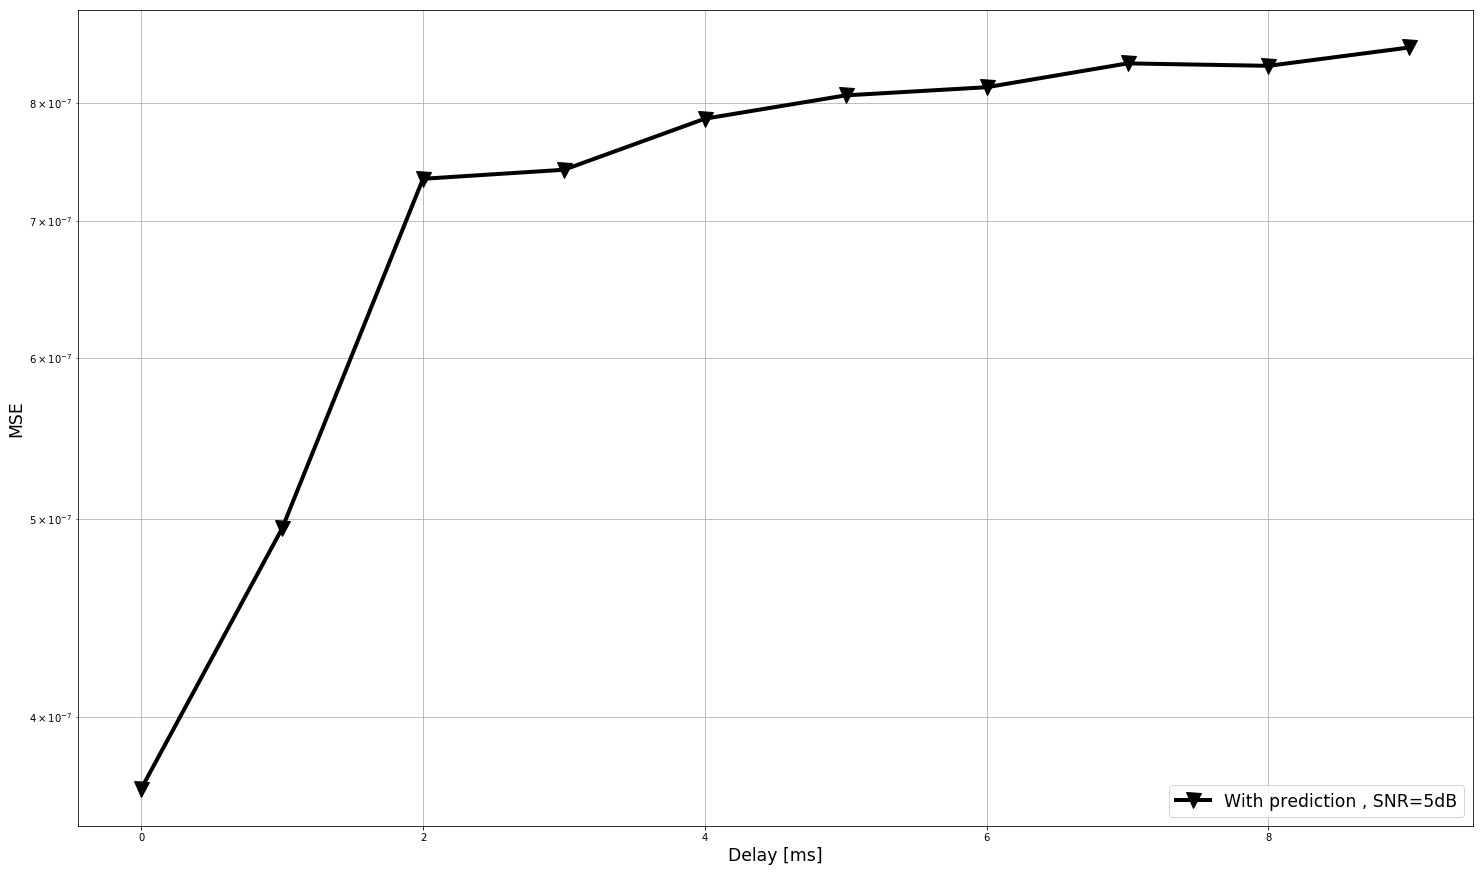

In [5]:
tx_bw = 15e3 * 72 # Tranmission Bandwidth
mse_no=np.zeros([maximum_delay + 1,len(snrs_set)])
mse_with=np.zeros([maximum_delay + 1,len(snrs_set)])



for delay_index in range(0,maximum_delay+ 1):
    
    for snr_index in [0,1,2]:

        mse_with[delay_index,snr_index] = (mean_squared_error_with_prediction[len(snrs_set)*delay_index+snr_index][snrs_set[snr_index]-1])/ tx_bw

plt.figure( figsize = [ 25, 15 ] )
plt.ylabel('MSE',fontsize = 'xx-large')
plt.xlabel('Delay [ms]',fontsize = 'xx-large')

plt.semilogy( delays, mse_with[:,0], marker = 'v',color='black',label='With prediction , SNR=5dB' )
plt.grid(which = 'both')
plt.legend()
plt.legend(fontsize = 'xx-large',loc = 'lower right', ncol = 3)
plt.show()